# Loading libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Loading the data

In [2]:
df = pd.read_csv('DataFiles\Boston_Housing_from_Sklearn.csv')
df.head()

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT,PRICE
0,0.00632,0.538,6.575,65.2,15.3,4.98,24.0
1,0.02731,0.469,6.421,78.9,17.8,9.14,21.6
2,0.02729,0.469,7.185,61.1,17.8,4.03,34.7
3,0.03237,0.458,6.998,45.8,18.7,2.94,33.4
4,0.06905,0.458,7.147,54.2,18.7,5.33,36.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   NOX      506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   PTRATIO  506 non-null    float64
 5   LSTAT    506 non-null    float64
 6   PRICE    506 non-null    float64
dtypes: float64(7)
memory usage: 27.8 KB


In [4]:
df.duplicated().sum()

0

# Splitting the data

In [5]:
X = df.drop(columns = 'PRICE')
y = df['PRICE']
X

,CRIM,NOX,RM,AGE,PTRATIO,LSTAT
0,0.00632,0.538,6.575,65.2,15.3,4.98
1,0.02731,0.469,6.421,78.9,17.8,9.14
2,0.02729,0.469,7.185,61.1,17.8,4.03
3,0.03237,0.458,6.998,45.8,18.7,2.94
4,0.06905,0.458,7.147,54.2,18.7,5.33
...,...,...,...,...,...,...
501,0.06263,0.573,6.593,69.1,21.0,9.67
502,0.04527,0.573,6.120,76.7,21.0,9.08
503,0.06076,0.573,6.976,91.0,21.0,5.64
504,0.10959,0.573,6.794,89.3,21.0,6.48


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Functions
I'm going to repeat code a couple of times, so I'll create some functions to save me time

## Model Evaluation
Simple function to score the models

In [7]:
def evaluate_model(y_true, y_pred, name = 'model'):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f'{name} Scores:')
    print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

# Decision Tree
Lets begin with the simplest tree and start tuning the parameters in the model

In [8]:
DECtree = DecisionTreeRegressor(random_state = 42)
DECtree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [9]:
y_hat_test = DECtree.predict(X_test)
y_hat_train = DECtree.predict(X_train)

evaluate_model(y_train, y_hat_train, name = 'Training Data')
evaluate_model(y_test, y_hat_test, name = 'Testing Data')


Training Data Scores:
MAE: 0.0000 
MSE: 0.0000 
RMSE: 0.0000 
R2: 1.0000

Testing Data Scores:
MAE: 3.1409 
MSE: 26.6577 
RMSE: 5.1631 
R2: 0.6193



* The base tree is clearly overfit. Lets see if we can tune the depth and find a better fit

In [10]:
DECtree.get_depth()

20

## Depth
I'm going to run a loop through depths. The original tree had a depth of 20, so I'll loop through 2-20 and plot the scores

In [11]:
# Creating a list of depth values to loop through
depths = list(range(2,21))
# Creating a dataframe to store the resulting scores for each depth
scores = pd.DataFrame(index = depths, columns = ['Test Score', 'Training Score'])
for i in depths:
    tree = DecisionTreeRegressor(max_depth = i, random_state = 42)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    scores.loc[i, 'Test Score'] = test_score
    scores.loc[i, 'Training Score'] = train_score

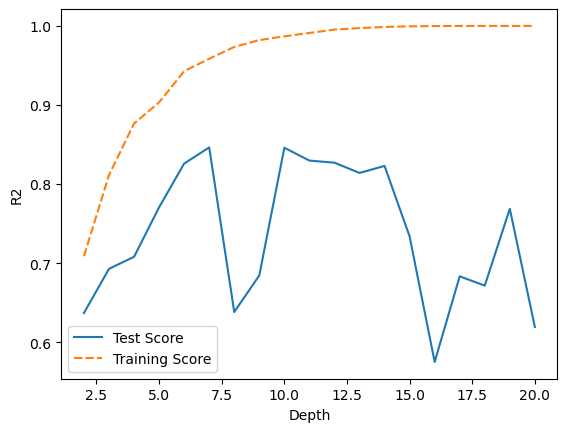

In [12]:
fig, ax = plt.subplots()
sns.lineplot(data = scores)
ax.set_xlabel('Depth')
ax.set_ylabel('R2');

In [13]:
scores.sort_values(by = 'Test Score', ascending=False).head()

,Test Score,Training Score
7,0.846377,0.958517
10,0.84601,0.986796
11,0.829736,0.9911
12,0.827102,0.995358
6,0.825985,0.942742


* Looks like 7 is the best depth. Lets rerun it

In [14]:
DECtree = DecisionTreeRegressor(random_state = 42, max_depth = 7)
DECtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [15]:
y_hat_test_dt = DECtree.predict(X_test)
y_hat_train_dt = DECtree.predict(X_train)

evaluate_model(y_train, y_hat_train_dt, name = 'Training Data')
evaluate_model(y_test, y_hat_test_dt, name = 'Testing Data')

Training Data Scores:
MAE: 1.3467 
MSE: 3.6788 
RMSE: 1.9180 
R2: 0.9585

Testing Data Scores:
MAE: 2.4472 
MSE: 10.7578 
RMSE: 3.2799 
R2: 0.8464



* Much better. We will keep this tree

# Bagged Tree
Lets create a base bagged tree and analyze its scores

In [16]:
BAGtree = BaggingRegressor(random_state = 42)
BAGtree.fit(X_train, y_train)

BaggingRegressor(random_state=42)

In [17]:
y_hat_test_bag = BAGtree.predict(X_test)
y_hat_train_bag = BAGtree.predict(X_train)

evaluate_model(y_train, y_hat_train_bag, name = 'Training Data')
evaluate_model(y_test, y_hat_test_bag, name = 'Testing Data')

Training Data Scores:
MAE: 1.1033 
MSE: 3.4874 
RMSE: 1.8674 
R2: 0.9607

Testing Data Scores:
MAE: 2.3155 
MSE: 12.5754 
RMSE: 3.5462 
R2: 0.8204



## Estimators
* Starting off at a good place. Lets see if we can do better by changing the number of estimators

In [18]:
# Creating a list of evenly spaced estimators from 10 to 300
estimators = np.linspace(10,300,30,dtype=int)

scores = pd.DataFrame(index = estimators, columns = ['Test Score', 'Training Score'])
for i in estimators:
    tree = BaggingRegressor(n_estimators = i, random_state = 42)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    scores.loc[i, 'Test Score'] = test_score
    scores.loc[i, 'Training Score'] = train_score

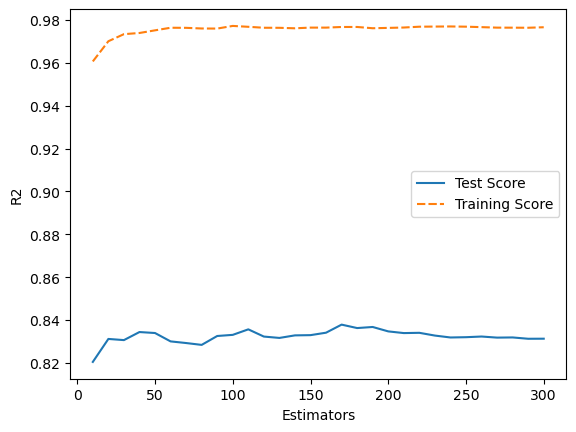

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data = scores)
ax.set_xlabel('Estimators')
ax.set_ylabel('R2');

In [20]:
scores.sort_values(by = 'Test Score', ascending=False).head()

,Test Score,Training Score
170,0.837828,0.976748
190,0.836727,0.976164
180,0.836226,0.976757
110,0.835623,0.976833
200,0.834672,0.976328


* It looks like the best estimators from my loop is 170.

In [21]:
BAGtree = BaggingRegressor(random_state = 42, n_estimators = 170)
BAGtree.fit(X_train, y_train)

BaggingRegressor(n_estimators=170, random_state=42)

In [22]:
y_hat_test_bag = BAGtree.predict(X_test)
y_hat_train_bag = BAGtree.predict(X_train)

evaluate_model(y_train, y_hat_train_bag, name = 'Training Data')
evaluate_model(y_test, y_hat_test_bag, name = 'Testing Data')

Training Data Scores:
MAE: 0.9559 
MSE: 2.0621 
RMSE: 1.4360 
R2: 0.9767

Testing Data Scores:
MAE: 2.1617 
MSE: 11.3564 
RMSE: 3.3699 
R2: 0.8378



# Random Forest Tree
* Same as before, lets create a base model and evaluate it.

In [23]:
RANDtree = RandomForestRegressor(random_state = 42)
RANDtree.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
y_hat_test_rand = RANDtree.predict(X_test)
y_hat_train_rand = RANDtree.predict(X_train)

evaluate_model(y_train, y_hat_train_rand, name = 'Training Data')
evaluate_model(y_test, y_hat_test_rand, name = 'Testing Data')

Training Data Scores:
MAE: 0.9535 
MSE: 2.0278 
RMSE: 1.4240 
R2: 0.9771

Testing Data Scores:
MAE: 2.2079 
MSE: 11.6348 
RMSE: 3.4110 
R2: 0.8339



## Depth
Lets find the max depth for the base model and loop through those depths

In [25]:
rf_depths = [i.get_depth() for i in RANDtree.estimators_]
max(rf_depths)

23

In [26]:
# Creating a list of depth values to loop through
depths = list(range(2,24))
# Creating a dataframe to store the resulting scores for each depth
scores = pd.DataFrame(index = depths, columns = ['Test Score', 'Training Score'])
for i in depths:
    tree = RandomForestRegressor(max_depth = i, random_state = 42)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    scores.loc[i, 'Test Score'] = test_score
    scores.loc[i, 'Training Score'] = train_score

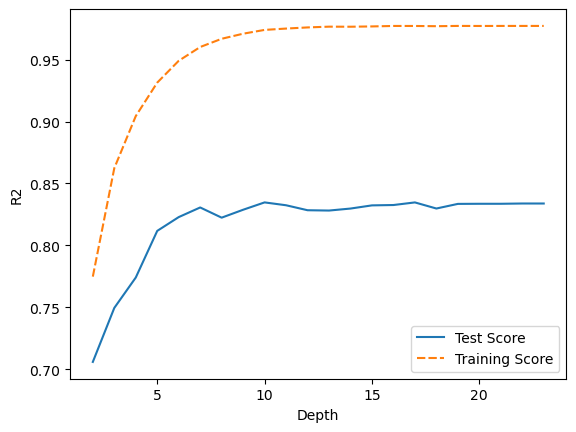

In [27]:
fig, ax = plt.subplots()
sns.lineplot(data = scores)
ax.set_xlabel('Depth')
ax.set_ylabel('R2');

In [28]:
scores.sort_values(by = 'Test Score', ascending=False).head()

,Test Score,Training Score
10,0.834747,0.973927
17,0.834732,0.977102
22,0.83386,0.977134
23,0.833853,0.977134
20,0.833637,0.977103


* 10 looks to be the best value here. Now to look through the estimators

## Estimators

In [29]:
# Creating a list of evenly spaced estimators from 10 to 300
estimators = np.linspace(10,300,30,dtype=int)

scores = pd.DataFrame(index = estimators, columns = ['Test Score', 'Training Score'])
for i in estimators:
    tree = RandomForestRegressor(n_estimators = i, random_state = 42, max_depth = 10)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    scores.loc[i, 'Test Score'] = test_score
    scores.loc[i, 'Training Score'] = train_score

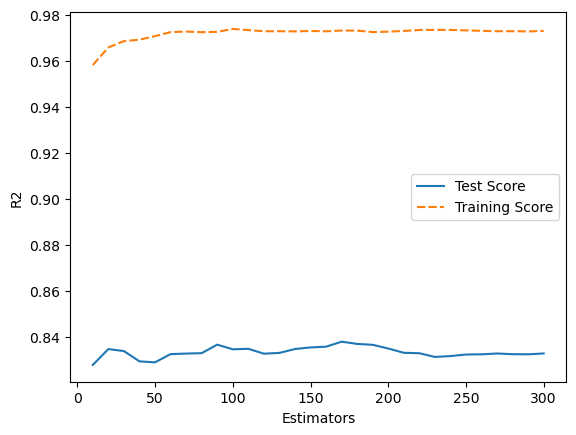

In [30]:
fig, ax = plt.subplots()
sns.lineplot(data = scores)
ax.set_xlabel('Estimators')
ax.set_ylabel('R2');

In [31]:
scores.sort_values(by = 'Test Score', ascending=False).head()

,Test Score,Training Score
170,0.838053,0.973228
180,0.837084,0.973207
90,0.836767,0.972643
190,0.836696,0.972549
160,0.835878,0.972905


* Best fit here is 170. I'll use n_estimators = 170 and max_depth = 10

In [32]:
RANDtree = RandomForestRegressor(random_state = 42, n_estimators = 170, max_depth = 10)
RANDtree.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=170, random_state=42)

In [33]:
y_hat_test_rand = RANDtree.predict(X_test)
y_hat_train_rand = RANDtree.predict(X_train)

evaluate_model(y_train, y_hat_train_rand, name = 'Training Data')
evaluate_model(y_test, y_hat_test_rand, name = 'Testing Data')

Training Data Scores:
MAE: 1.0937 
MSE: 2.3742 
RMSE: 1.5408 
R2: 0.9732

Testing Data Scores:
MAE: 2.1735 
MSE: 11.3407 
RMSE: 3.3676 
R2: 0.8381



# Final Analysis

In [36]:
# Decision Tree
evaluate_model(y_test, y_hat_test_dt, name = 'DT Testing Data')

# Bagged Tree
evaluate_model(y_test, y_hat_test_bag, name = 'BAG Testing Data')

# Random Forest
evaluate_model(y_test, y_hat_test_rand, name = 'RF Testing Data')

DT Testing Data Scores:
MAE: 2.4472 
MSE: 10.7578 
RMSE: 3.2799 
R2: 0.8464

BAG Testing Data Scores:
MAE: 2.1617 
MSE: 11.3564 
RMSE: 3.3699 
R2: 0.8378

RF Testing Data Scores:
MAE: 2.1735 
MSE: 11.3407 
RMSE: 3.3676 
R2: 0.8381



## Model to use, and why
* Each model was tuned to ensure it was not overfit. From the metrics for each model on the testing data, the best fit model is a simple Decision Tree Regressor with a max depth of 7. Although it had the highest MAE, it had the best RMSE and the best R2.
    * We should expect the model to explain 84.64% of the variation in PRICE to be explained by the features in the dataset. 
    * We should expect an absolute error of about 2.45. while minimizing large errors. 